In [6]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize
import torch
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def create_bert_embeddings(csv_file_path, output_file_path):
    """
    Create BERT embeddings for reviews using sentence-transformers
    
    Parameters:
    csv_file_path (str): Path to the input CSV file
    output_file_path (str): Path to save the output CSV file
    """
    
    print("Loading data...")
    # Load the data
    df = pd.read_csv(csv_file_path)
    
    # Check if required columns exist
    required_columns = ['Game', 'cleaned_Reviews']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Required column '{col}' not found in the dataset")
    
    print(f"Loaded {len(df)} reviews")
    
    # Remove duplicates based on cleaned_Reviews to ensure unique embeddings
    print("Removing duplicate reviews...")
    df_unique = df.drop_duplicates(subset=['cleaned_Reviews'], keep='first').reset_index(drop=True)
    print(f"After removing duplicates: {len(df_unique)} unique reviews")
    
    # Initialize BERT model for embeddings
    print("Loading BERT model...")
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    print("Creating embeddings...")
    
    # Prepare reviews for embedding
    reviews = df_unique['cleaned_Reviews'].fillna('').astype(str).tolist()
    
    # Create embeddings in batches to manage memory
    batch_size = 32
    embeddings = []
    
    for i in tqdm(range(0, len(reviews), batch_size), desc="Processing batches"):
        batch_reviews = reviews[i:i + batch_size]
        batch_embeddings = model.encode(batch_reviews, 
                                        convert_to_tensor=False,
                                        show_progress_bar=False,
                                        normalize_embeddings=True)
        embeddings.extend(batch_embeddings)
    
    embeddings = np.array(embeddings)
    print(f"Created embeddings with shape: {embeddings.shape}")
    
    # Create DataFrame with embeddings
    print("Preparing output DataFrame...")
    embedding_columns = [f'embedding_{i}' for i in range(embeddings.shape[1])]
    embedding_df = pd.DataFrame(embeddings, columns=embedding_columns)
    
    # Combine with original data
    result_df = pd.concat([df_unique[['Game', 'cleaned_Reviews']].reset_index(drop=True),
                           embedding_df], axis=1)
    
    # Add additional useful columns
    result_df['num_words'] = result_df['cleaned_Reviews'].apply(lambda x: len(str(x).split()))
    result_df['review_length'] = result_df['cleaned_Reviews'].apply(lambda x: len(str(x)))
    
    # Reorder columns
    cols = ['Game', 'cleaned_Reviews', 'num_words', 'review_length'] + embedding_columns
    result_df = result_df[cols]
    
    # Save to CSV
    print(f"Saving embeddings to {output_file_path}...")
    result_df.to_csv(output_file_path, index=False)
    
    print("Embedding creation completed!")
    print(f"Final dataset shape: {result_df.shape}")
    print(f"Embedding dimensions: {len(embedding_columns)}")
    
    return result_df

def verify_embeddings(df):
    """
    Verify that embeddings are unique and properly created
    """
    print("\n=== EMBEDDING VERIFICATION ===")
    
    # Check for duplicate embeddings
    embedding_cols = [col for col in df.columns if col.startswith('embedding_')]
    embeddings = df[embedding_cols].values
    
    unique_embeddings = np.unique(embeddings, axis=0)
    print(f"Total embeddings: {len(embeddings)}")
    print(f"Unique embeddings: {len(unique_embeddings)}")
    
    if len(embeddings) == len(unique_embeddings):
        print("✅ All embeddings are unique!")
    else:
        print(f"⚠️ Found {len(embeddings) - len(unique_embeddings)} duplicate embeddings")
    
    print(f"\nEmbedding statistics:")
    print(f"Mean: {embeddings.mean():.6f}")
    print(f"Std: {embeddings.std():.6f}")
    print(f"Min: {embeddings.min():.6f}")
    print(f"Max: {embeddings.max():.6f}")
    
    # Check for any NaN values
    nan_count = np.isnan(embeddings).sum()
    if nan_count == 0:
        print("✅ No NaN values found in embeddings")
    else:
        print(f"⚠️ Found {nan_count} NaN values in embeddings")
    
    # Show sample of different reviews and their embedding differences
    print(f"\nSample verification - checking if different reviews have different embeddings:")
    for i in range(min(3, len(df)-1)):
        review1 = df.iloc[i]['cleaned_Reviews'][:50] + "..."
        review2 = df.iloc[i+1]['cleaned_Reviews'][:50] + "..."
        
        emb1 = embeddings[i]
        emb2 = embeddings[i+1]
        
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        
        print(f"\nReview {i+1}: {review1}")
        print(f"Review {i+2}: {review2}")
        print(f"Embedding similarity: {similarity:.4f}")

# Example usage and main execution
if __name__ == "__main__":
    input_file = "preprocessed_Reviews.csv"
    output_file = "embedding_bertopic_v2.csv"
    
    try:
        df_with_embeddings = create_bert_embeddings(input_file, output_file)
        verify_embeddings(df_with_embeddings)
        
        print(f"\n=== DATASET INFO ===")
        print(f"Shape: {df_with_embeddings.shape}")
        print(f"Columns: {list(df_with_embeddings.columns[:10])}...")
        print(f"\nSample data:")
        print(df_with_embeddings[['Game', 'cleaned_Reviews', 'num_words']].head())
        
    except Exception as e:
        print(f"Error: {e}")
        print("Please make sure you have the required libraries installed:")
        print("pip install sentence-transformers pandas numpy scikit-learn torch tqdm")


Loading data...
Loaded 369 reviews
Removing duplicate reviews...
After removing duplicates: 356 unique reviews
Loading BERT model...
Creating embeddings...


Processing batches: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]

Created embeddings with shape: (356, 384)
Preparing output DataFrame...
Saving embeddings to embedding_bertopic_v2.csv...
Embedding creation completed!
Final dataset shape: (356, 388)
Embedding dimensions: 384

=== EMBEDDING VERIFICATION ===
Total embeddings: 356
Unique embeddings: 356
✅ All embeddings are unique!

Embedding statistics:
Mean: 0.000082
Std: 0.051031
Min: -0.242105
Max: 0.406218
✅ No NaN values found in embeddings

Sample verification - checking if different reviews have different embeddings:

Review 1: major negative story character lame everything com...
Review 2: meh big meh bland storyline japanese melodrama ton...
Embedding similarity: 0.5064

Review 2: meh big meh bland storyline japanese melodrama ton...
Review 3: honestly insane I use play ace combat game ps I co...
Embedding similarity: 0.3615

Review 3: honestly insane I use play ace combat game ps I co...
Review 4: I never play anything series one fun dogfighting g...
Embedding similarity: 0.4792

=== DATASET 

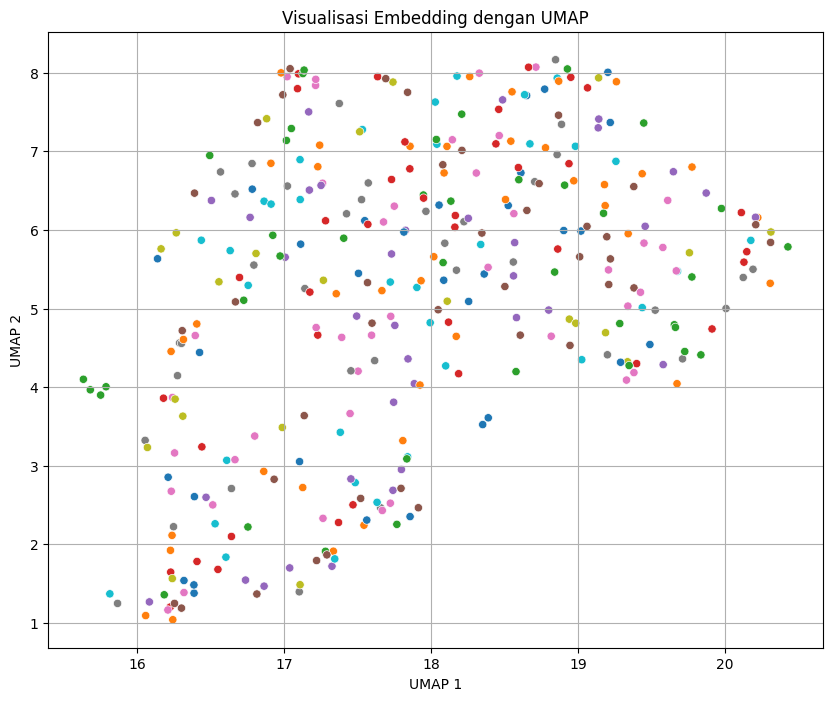

In [7]:
# 1. Import library
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Load data
df = pd.read_csv("embedding_bertopic_v2.csv")

# 3. Ambil hanya kolom embedding (diasumsikan dimulai dari kolom ke-4)
embedding_cols = [col for col in df.columns if col.startswith("embedding_")]
embeddings = df[embedding_cols].values

# 4. Reduksi dimensi dengan UMAP ke 2D
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_embeddings = umap_model.fit_transform(embeddings)

# 5. Tambahkan hasil UMAP ke dataframe
df['UMAP_1'] = umap_embeddings[:, 0]
df['UMAP_2'] = umap_embeddings[:, 1]

# 6. Visualisasi hasil
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x="UMAP_1", y="UMAP_2", hue="Game", palette="tab10", legend=False)
plt.title("Visualisasi Embedding dengan UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()


In [8]:
df.to_csv("embedding_umap.csv", index=False)

In [9]:
import pandas as pd

# Baca file CSV
df = pd.read_csv("embedding_umap.csv")

# Hapus kolom dari embedding_1 hingga embedding_383
embedding_columns = [f"embedding_{i}" for i in range(1, 384)]
df = df.drop(columns=embedding_columns)

# Simpan ke file baru (atau timpa file lama jika mau)
df.to_csv("embedding_umap.csv", index=False)